# Performance of SVMs in Large Datasets

The main idea of this document is to evaluate and analyze the behavior of support vector machines in large datasets and implement some alternative methods such as Cascade SVMs, Bagging-Like SVMs adn Stepwise Baggind SVMs. 

The idea for doing this notebook rises from reading [Studies in Classification, Data Analysis, and Knowledge Organization](https://link.springer.com/bookseries/1564).

In [2]:
#Loading all the required libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import scipy as sc
import random as rd
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn import datasets,svm,metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_digits
from sklearn import preprocessing
import matplotlib.pylab as plt

## MNIST Digits Dataset

Let's use the MNIST dataset as a first example and let's check the size of the dataset and the dimension of the input space.

In [3]:
#Loading train and test datasets
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print('The shape of train images is ' + np.str(train_images.shape))
print('The shape of test images is ' + np.str(test_images.shape))

The shape of train images is (60000, 28, 28)
The shape of test images is (10000, 28, 28)


In [4]:
#Normalizing pixels, so the take values from 0 to 1
train_images, test_images = train_images/255.0, test_images/255.0

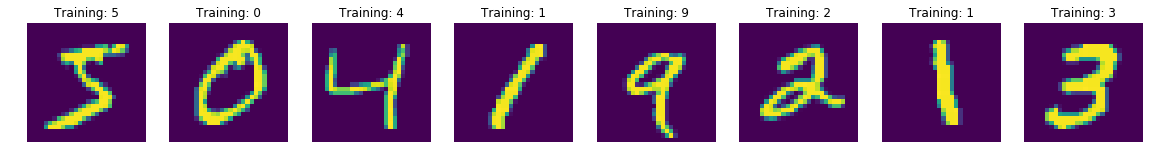

In [15]:
#Let's visualizate the digits (the first n digits)
n = 8
plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.axis('off')
    plt.imshow(train_images[i,:].reshape((28,28)))
    plt.title('Training: %i' % train_labels[i]) 

In [5]:
#How many labels there are? 10: the digits from 0 to 9
size_labels = len(np.unique(train_labels)) ; size_labels

10

In [6]:
#We have to reshape the data (extend the pixels in one arrange)
train_images_svm = train_images.reshape(len(train_images), 28*28)
test_images_svm = test_images.reshape(len(test_images), 28*28)
print('The shape of train images is ' + np.str(train_images_svm.shape))
print('The shape of test images is ' + np.str(test_images_svm.shape))

The shape of train images is (60000, 784)
The shape of test images is (10000, 784)


In [7]:
#Function which objective is to plot in a fancy way the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    fig, ax = plt.subplots(figsize = (10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## SVMs Performance and Analysis

The main idea of this section is to see the behavior of regular SVMs in diferent subsamples of the original data.

In [8]:
#We generate a random order of the sample 
random_order = rd.sample(range(len(train_images_svm)), len(train_images_svm))
np.sort(random_order)

array([    0,     1,     2, ..., 59997, 59998, 59999])

In [9]:
#Pick a number multiple of len(train_images_svm)=60000
size_subsample = 10000
total_of_subsamples = np.int(len(train_images_svm)/size_subsample) ; total_of_subsamples

6

In [10]:
#We pick one subsample of size size_subsample and evaluate it doing SVMs
number_of_subsample = rd.randint(0,total_of_subsamples-1) 
first = number_of_subsample*size_subsample
last = (number_of_subsample+1)*size_subsample
values = random_order[first:last]

train_subsample_images = train_images_svm[values,:]
train_subsample_labels = train_labels[values]
train_subsample_images.shape

(10000, 784)

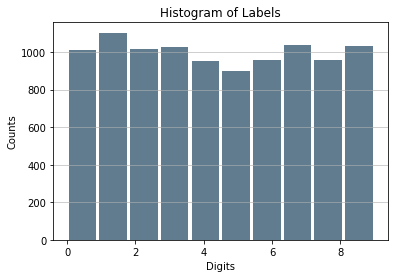

In [11]:
#Histogram of the labels. The idea is to veirfy that the digits are balanced
train_subsample_labels_pd = pd.DataFrame(train_subsample_labels)
train_subsample_labels_pd.plot.hist(grid=False, bins=10, rwidth=0.9, color='#607c8e', legend=None)
plt.title('Histogram of Labels')
plt.xlabel('Digits')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [12]:
#Let's evlauate different C's 
c = np.logspace(-5, 5, 11, base=2)
c_score=[]
for c_value in c:
    clf =  svm.SVC(C = c_value, gamma=0.0001, kernel='linear')
    score=cross_val_score(clf, train_subsample_images, train_subsample_labels, cv = 5)
    c_score.append(score.mean())
    print(c_value)
print('The maximum score in the test dataset is ' + np.str(np.max(c_score)) + ' with C = ' 
      + np.str(c[np.argmax(c_score)]))

0.03125
0.0625
0.125
0.25
0.5
1.0
2.0
4.0
8.0
16.0
32.0
The maximum score in the test dataset is 0.9279041074943413 with C = 0.0625


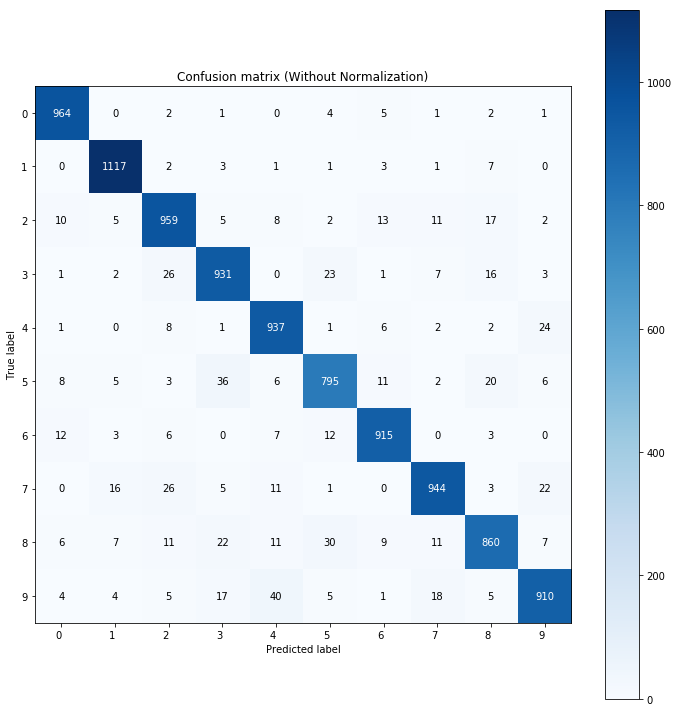

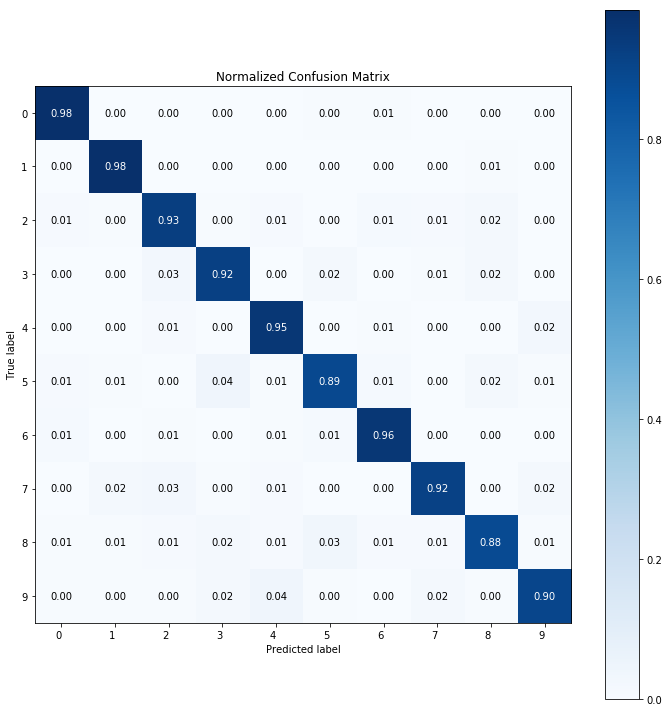

In [13]:
clf = svm.SVC(C = c[np.argmax(c_score)], gamma=0.0001, kernel='linear')
clf.fit(train_subsample_images, train_subsample_labels)
predicted = clf.predict(test_images_svm)

np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, predicted, classes=np.sort(np.unique(train_labels)),
                      title='Confusion matrix (Without Normalization)')

plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, predicted, classes=np.sort(np.unique(train_labels)),
                      normalize=True, title='Normalized Confusion Matrix')

plt.show()

In [14]:
#Now predict the value of the digit on the second half:
expected = test_labels
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))

Classification report for classifier SVC(C=0.0625, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.93      0.92      1032
           3       0.91      0.92      0.92      1010
           4       0.92      0.95      0.94       982
           5       0.91      0.89      0.90       892
           6       0.95      0.96      0.95       958
           7       0.95      0.92      0.93      1028
           8       0.92      0.88      0.90       974
           9       0.93      0.90      0.92      1009

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93    

## Cascade SVMs Performance and Analysis

Let's create a function which objective is to implement [Cascade SVMs](https://pdfs.semanticscholar.org/61ab/f3eb0f653b67c0eb42c527b6620db51d4f3f.pdf).

In [16]:
#Cascade SVM
#@data: The data predictors
#@target: The target labels
#@kernel: The type of kernel
#@gamma: The Gamma of svm.SVC
#@layers: The number of layers (the repeats in the method)
#@number_of_partitions: A vector of partitions to be done in each layer
def CascadeSVM(data, target, kernel, gamma, number_of_layers, number_of_partitions, counting = 1):
    
    if number_of_layers != 0:
        #We generate a random order of the sample 
        random_order = rd.sample(range(len(data)), len(data))

        #Pick a number multiple of len(train_images_svm)=60000
        size_subsample = np.int(len(data)/number_of_partitions[0])

        support_vectors = []
        for partition in range(number_of_partitions[0]):
            first = partition*size_subsample
            last = (partition+1)*size_subsample
            values = random_order[first:last]
            data_partition = data[values,:]
            target_partition = target[values]
            
            #Let's evlauate different C's, UNCOMMENT THIS CODE IF YOU WANT TO PICK A C USING CV
            #c = np.logspace(-5, 4, 10, base=2)
            #c_score=[]
            #for c_value in c:
            #    clf =  svm.SVC(C = c, gamma=gamma, kernel=kernel)
            #    score=cross_val_score(clf, data_partition, target_partition, cv = 5)
            #    c_score.append(score.mean())
            #c[np.argmax(c_score)]
            
            
            clf = svm.SVC(C = 0.05, gamma=gamma, kernel=kernel)
            clf.fit(data_partition, target_partition)
            vectors = clf.support_ + first
            support_vectors = np.r_[support_vectors,vectors]
            #print('Layer ' + np.str(counting) + ' and Partition ' + np.str(partition+1) )
        
        #Create the new data,target, layers and partitions
        support_vectors = support_vectors.astype(int)
        
        random_order = np.array(random_order)
        new_data = data[random_order[support_vectors],:]
        new_target = target[random_order[support_vectors]]
        new_number_of_layers = number_of_layers-1
        new_number_of_partitions = np.delete(number_of_partitions, 0)
        print('The layer No.' + np.str(counting) + ' has been completed with ' +
              np.str(len(support_vectors)) + ' support vectors')
        
        return CascadeSVM(data=new_data, target=new_target, number_of_layers=new_number_of_layers,
                          kernel=kernel, gamma=gamma, number_of_partitions=new_number_of_partitions,
                          counting=counting+1)
    else:
        #Let's evlauate different C's, UNCOMMENT THIS CODE IF YOU WANT TO PICK A C USING CV
        #for c_value in c:
        #c = np.logspace(-5, 4, 10, base=2)
        #c_score=[]
        #    clf =  svm.SVC(C = c, gamma=gamma, kernel=kernel)
        #    score=cross_val_score(clf, data, target, cv = 5)
        #    c_score.append(score.mean())
        
        clf = svm.SVC(C = 0.05, gamma=gamma, kernel=kernel)
        clf.fit(data, target)
        return clf

In [17]:
number_of_partitions = [60, 30, 30, 30, 15, 15, 15, 5, 5, 5, 5, 5, 5, 5, 5]
#This will print us the number of layers
print(len(number_of_partitions))

15


In [18]:
clf = CascadeSVM(data=train_images_svm, target=train_labels, kernel='linear', gamma=0.0001,
                 number_of_layers=len(number_of_partitions), number_of_partitions=number_of_partitions)

The layer No.1 has been completed with 36265 support vectors
The layer No.2 has been completed with 27026 support vectors
The layer No.3 has been completed with 23591 support vectors
The layer No.4 has been completed with 21594 support vectors
The layer No.5 has been completed with 18770 support vectors
The layer No.6 has been completed with 17167 support vectors
The layer No.7 has been completed with 16067 support vectors
The layer No.8 has been completed with 13811 support vectors
The layer No.9 has been completed with 12705 support vectors
The layer No.10 has been completed with 11983 support vectors
The layer No.11 has been completed with 11424 support vectors
The layer No.12 has been completed with 10965 support vectors
The layer No.13 has been completed with 10586 support vectors
The layer No.14 has been completed with 10282 support vectors
The layer No.15 has been completed with 9989 support vectors


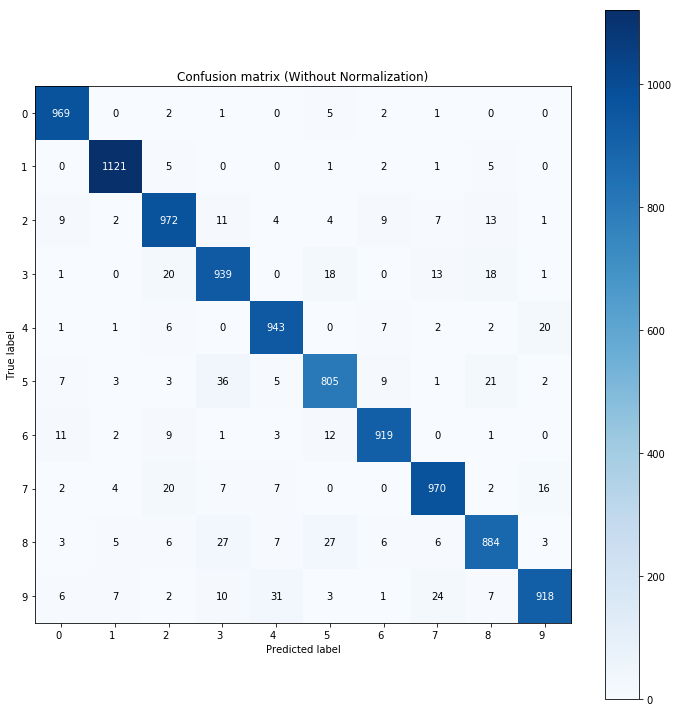

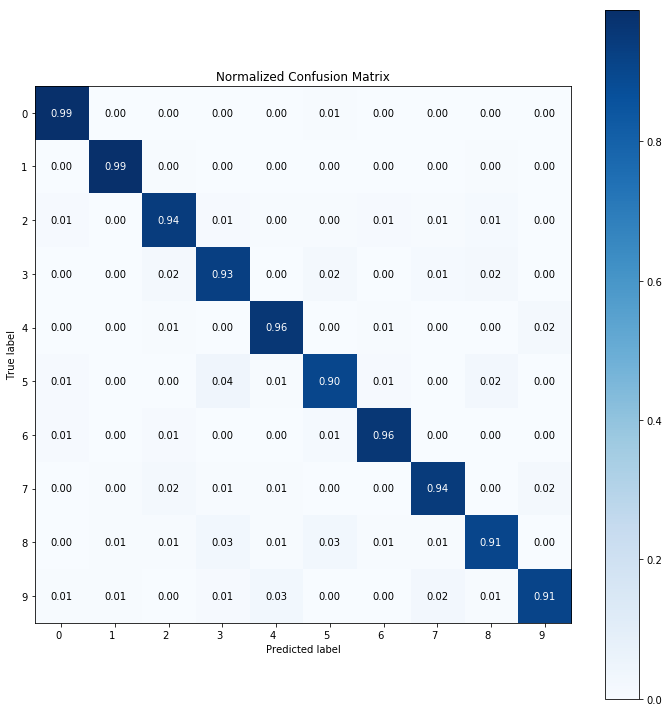

In [19]:
predicted = clf.predict(test_images_svm)

np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, predicted, classes=np.sort(np.unique(train_labels)),
                      title='Confusion matrix (Without Normalization)')

plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, predicted, classes=np.sort(np.unique(train_labels)),
                      normalize=True, title='Normalized Confusion Matrix')

plt.show()

In [20]:
#Now predict the value of the digit on the second half:
expected = test_labels
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))

Classification report for classifier SVC(C=0.05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.93      0.94      0.94      1032
           3       0.91      0.93      0.92      1010
           4       0.94      0.96      0.95       982
           5       0.92      0.90      0.91       892
           6       0.96      0.96      0.96       958
           7       0.95      0.94      0.94      1028
           8       0.93      0.91      0.92       974
           9       0.96      0.91      0.93      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      

We use the full dataset and obtain a 1% incremental in Precision, Recall and $F_1$-score by implementing a Cascada SVM with 15 layers with a final SVM with approx 10000 support vectors. 

Note that the number of support vectors appears to be converging. 

It remains to keep doing more and more combination of layers in order to reduce the error. 